In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import (
    Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense,
    MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, SeparableConv2D, UpSampling2D,
)
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps  # Pillow library
import random

# Additional imports from the code snippet
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from keras import models, layers
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical

# Set random seed
np.random.seed(1000)
# Ignore information messages from TensorFlow, but we will receive error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
PARENT_DATA_DIR = '/content/drive/MyDrive/Lung_dataset_21000'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'test')

In [4]:

IMG_SIZE = 64
dataset_classes = []
for i in os.listdir(TRAIN_DATA_DIR):
    dataset_classes.append(i)

number_of_classes = len(dataset_classes)
print(f"""

    Classes: {dataset_classes}
    Number of classes: {number_of_classes}""")



    Classes: ['Lung_Adenocarcinoma', 'Lung-Benign_Tissue', 'Lung_Squamous_Cell_Carcinoma']
    Number of classes: 3


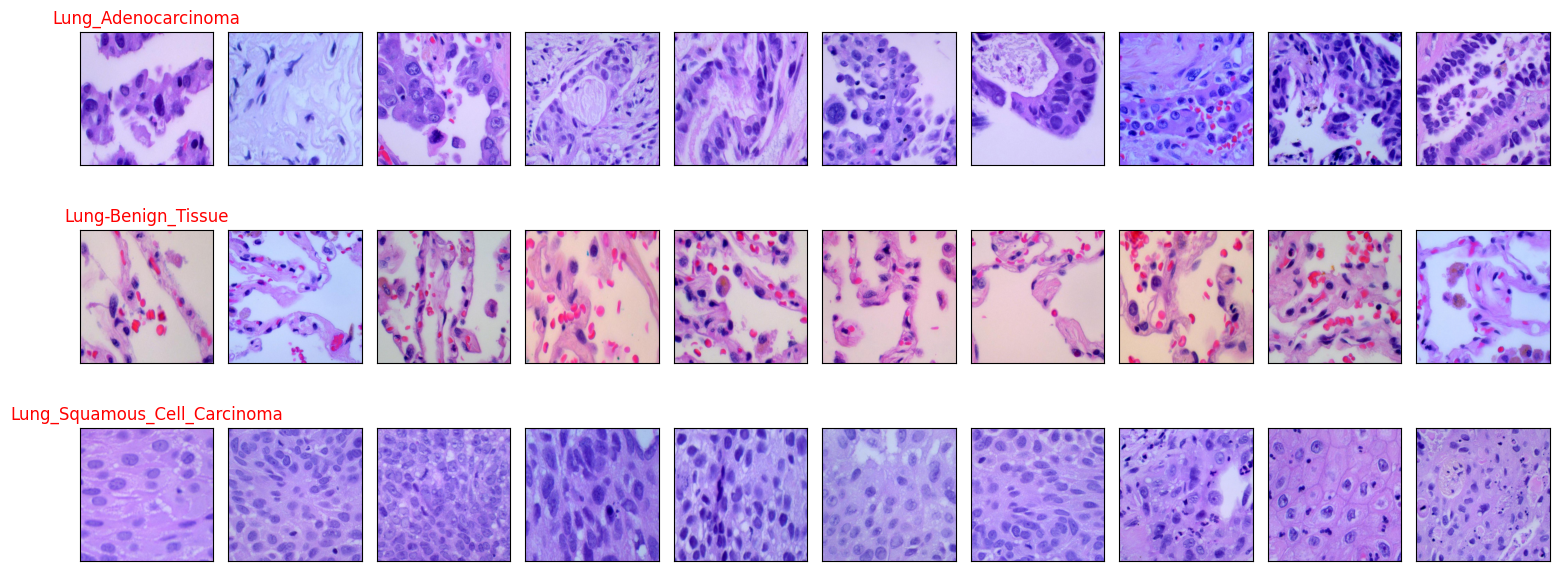

In [5]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in dataset_classes:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array
        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

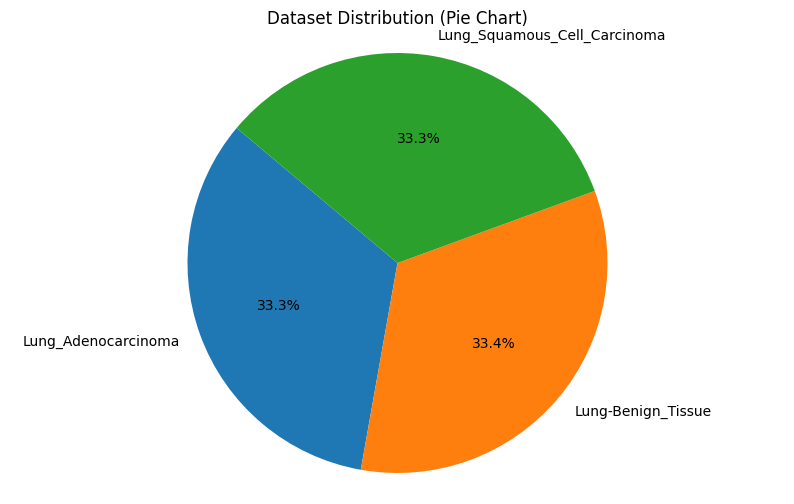

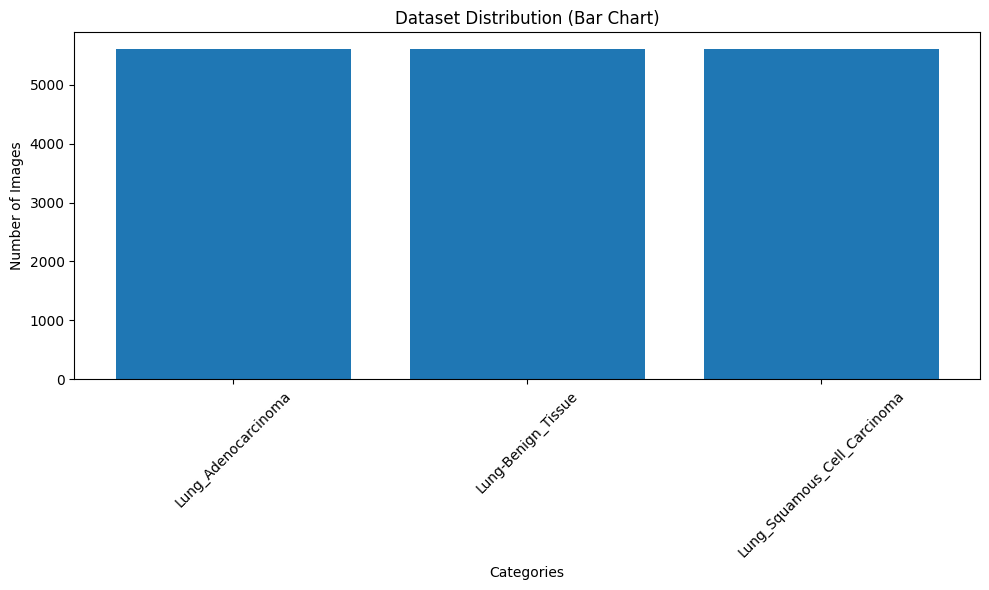

In [6]:
category_counts = {}
for category in dataset_classes:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in dataset_classes:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 5600/5600 [02:42<00:00, 34.52it/s] 

16810


In [ ]:
validation_data = []
for c in dataset_classes:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            validation_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(validation_data))

100%|██████████| 700/700 [00:16<00:00, 41.70it/s] 

2100


In [ ]:
test_data = []

for c in dataset_classes:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 700/700 [00:17<00:00, 39.76it/s] 

2100


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (16810, 64, 64, 3) Y_train= (16810,)


In [ ]:
X_valid = []
Y_valid = []

for features,label in validation_data:
    X_valid.append(features)
    Y_valid.append(label)

X_valid = np.array(X_valid).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (2100, 64, 64, 3) Y_valid= (2100,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

X_test= (2100, 64, 64, 3) Y_test= (2100,)


### CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


bcnn_model = keras.Sequential([
    ## input layer
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    ## hidden layers
    layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    # layers.Dropout(0.5),

    ## output layer
    layers.Dense(4, activation='softmax')
])


In [ ]:
bcnn_model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bcnn = bcnn_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.8454 - loss: 0.4108 - val_accuracy: 0.3333 - val_loss: 4.7280
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9475 - loss: 0.1342 - val_accuracy: 0.8171 - val_loss: 0.5163
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9761 - loss: 0.0749 - val_accuracy: 0.8986 - val_loss: 0.2618
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9849 - loss: 0.0504 - val_accuracy: 0.9329 - val_loss: 0.1766
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9922 - loss: 0.0340 - val_accuracy: 0.9514 - val_loss: 0.1232
Epoch 6/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9942 - loss: 0.0256 - val_accuracy: 0.9486 - val_loss: 0.1365
Epoch 7/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9974 - loss: 0.0172 - val_accuracy: 0.9476 - val_loss: 0.1513
Epoch 8/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9982 - loss: 0.0137 - val_

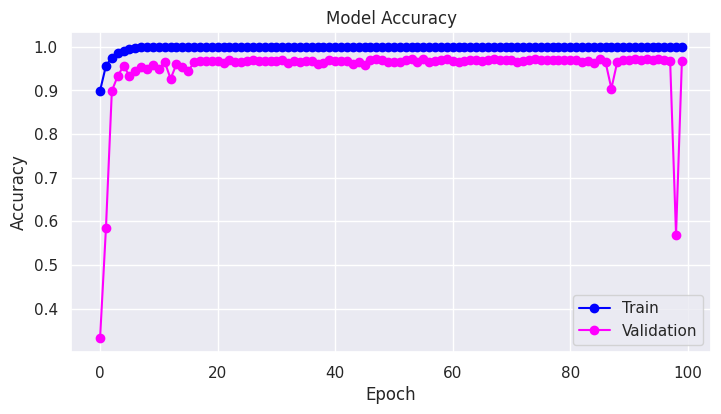

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['accuracy'], 'o-',color="blue")
plt.plot(bcnn.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

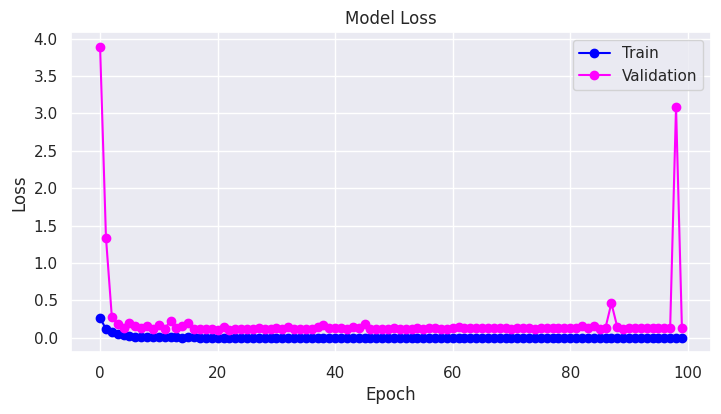

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['loss'],'o-', color="blue")
plt.plot(bcnn.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = bcnn_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=bcnn_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

525/525 [==============================] - 2s 4ms/step - loss: 6.7077e-05 - accuracy: 1.0000

Validation Accuracy: 0.9685714244842529

Validation Loss: 0.1335730403661728

Train Accuracy: 1.0

Train Loss: 6.707658030791208e-05


In [ ]:
score = bcnn_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  96.857 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(bcnn_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 40s 3ms/step
                              precision    recall  f1-score   support

Lung_Squamous_Cell_Carcinoma      0.969     0.944     0.957       700
          Lung-Benign_Tissue      0.999     0.993     0.996       700
         Lung_Adenocarcinoma      0.939     0.969     0.954       700

                    accuracy                          0.969      2100
                   macro avg      0.969     0.969     0.969      2100
                weighted avg      0.969     0.969     0.969      2100



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

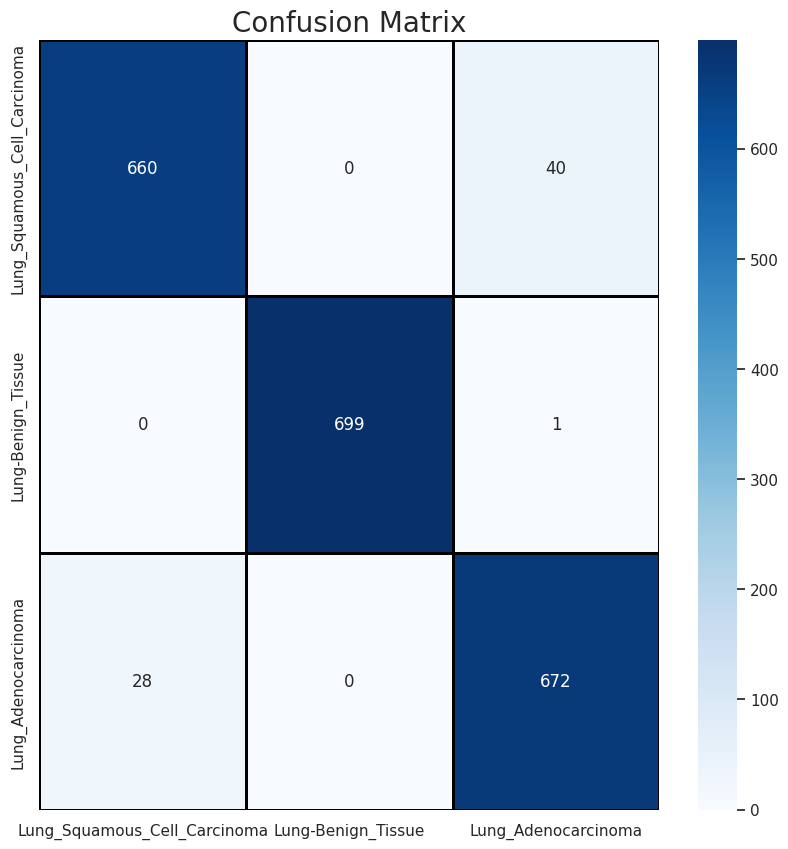

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

66/66 [==============================] - 0s 3ms/step


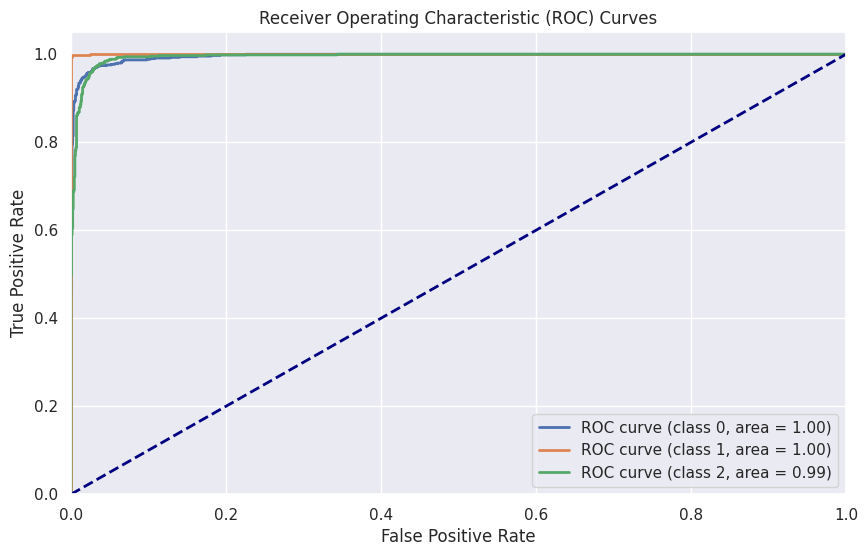

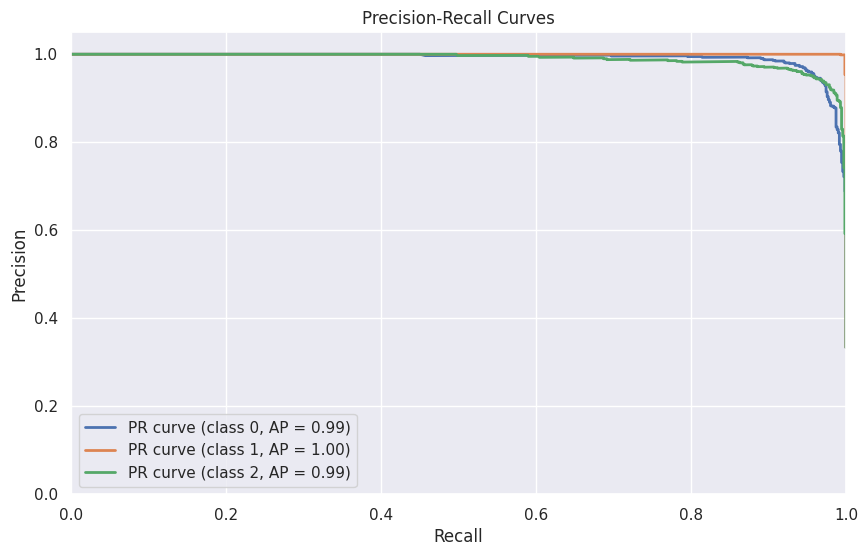

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = bcnn_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(bcnn_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 0s 4ms/step
                              precision    recall  f1-score   support

Lung_Squamous_Cell_Carcinoma      0.959     0.943     0.951       700
          Lung-Benign_Tissue      1.000     0.999     0.999       700
         Lung_Adenocarcinoma      0.942     0.960     0.951       700

                    accuracy                          0.967      2100
                   macro avg      0.967     0.967     0.967      2100
                weighted avg      0.967     0.967     0.967      2100



<Axes: title={'center': 'Confusion Matrix'}>

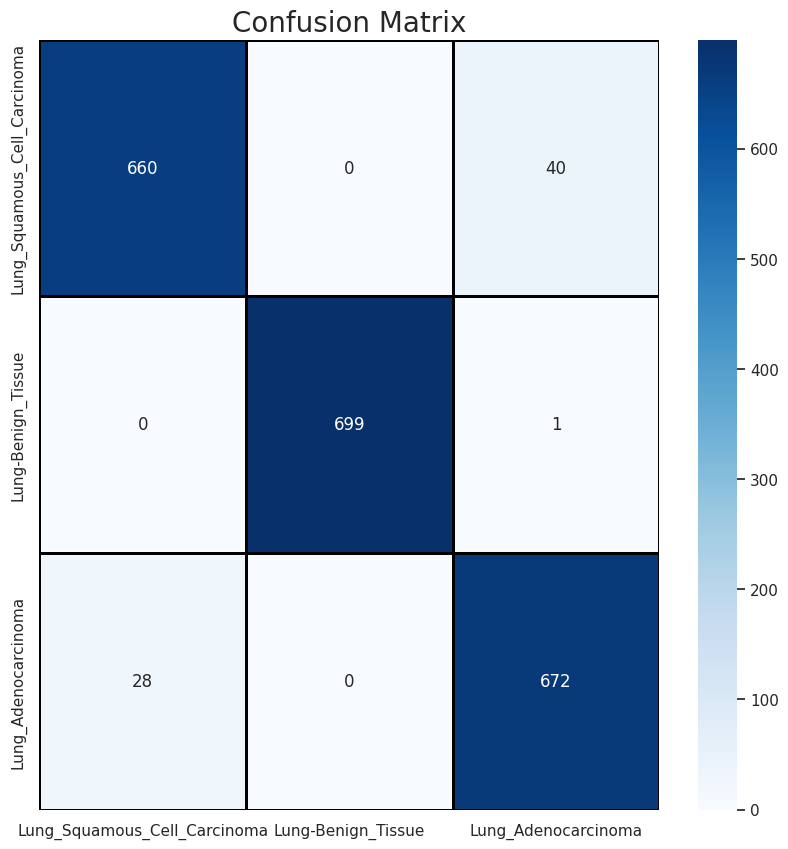

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### Efficientnet B4

In [ ]:
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB4(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)

e_model_b4 = tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

71892840/71892840 [==============================] - 1s 0us/step


In [ ]:
efficientnet_b4 = e_model_b4.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
263/263 [==============================] - 138s 166ms/step - loss: 0.2861 - accuracy: 0.9000 - val_loss: 1.0746 - val_accuracy: 0.8338
Epoch 2/100
263/263 [==============================] - 35s 134ms/step - loss: 0.0578 - accuracy: 0.9793 - val_loss: 0.0528 - val_accuracy: 0.9829
Epoch 3/100
263/263 [==============================] - 37s 140ms/step - loss: 0.0324 - accuracy: 0.9893 - val_loss: 0.0289 - val_accuracy: 0.9890
Epoch 4/100
263/263 [==============================] - 34s 131ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.0220 - val_accuracy: 0.9914
Epoch 5/100
263/263 [==============================] - 35s 134ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0081 - val_accuracy: 0.9967
Epoch 6/100
263/263 [==============================] - 36s 136ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.0114 - val_accuracy: 0.9962
Epoch 7/100
263/263 [==============================] - 35s 132ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0178 

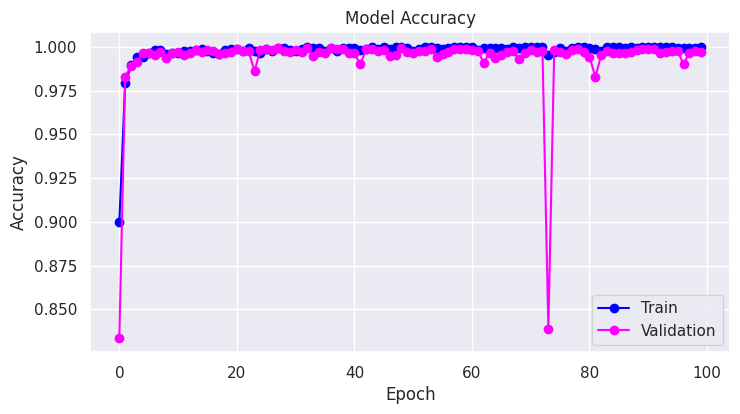

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['accuracy'], 'o-',color="blue")
plt.plot(efficientnet_b4.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

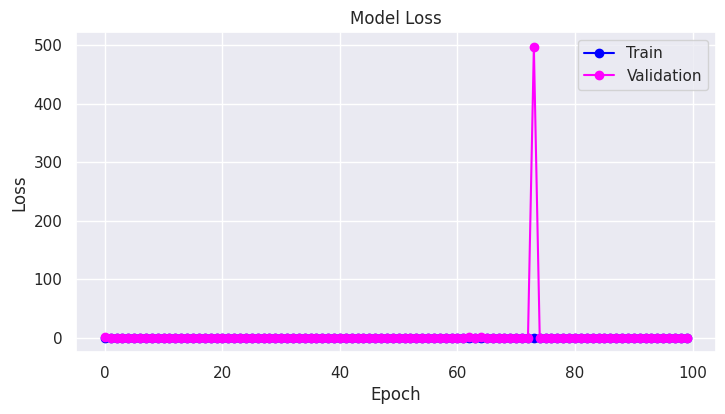

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['loss'],'o-', color="blue")
plt.plot(efficientnet_b4.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = e_model_b4.evaluate(X_valid, Y_valid)
train_loss, train_acc=e_model_b4.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

525/525 [==============================] - 12s 23ms/step - loss: 1.5251e-05 - accuracy: 1.0000

Validation Accuracy: 0.9971428513526917

Validation Loss: 0.008868515491485596

Train Accuracy: 1.0

Train Loss: 1.525105835753493e-05


In [ ]:
score = e_model_b4.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.714 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(e_model_b4.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 4s 21ms/step
                              precision    recall  f1-score   support

          Lung-Benign_Tissue      0.999     1.000     0.999       700
Lung_Squamous_Cell_Carcinoma      0.999     0.994     0.996       700
         Lung_Adenocarcinoma      0.994     0.997     0.996       700

                    accuracy                          0.997      2100
                   macro avg      0.997     0.997     0.997      2100
                weighted avg      0.997     0.997     0.997      2100



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

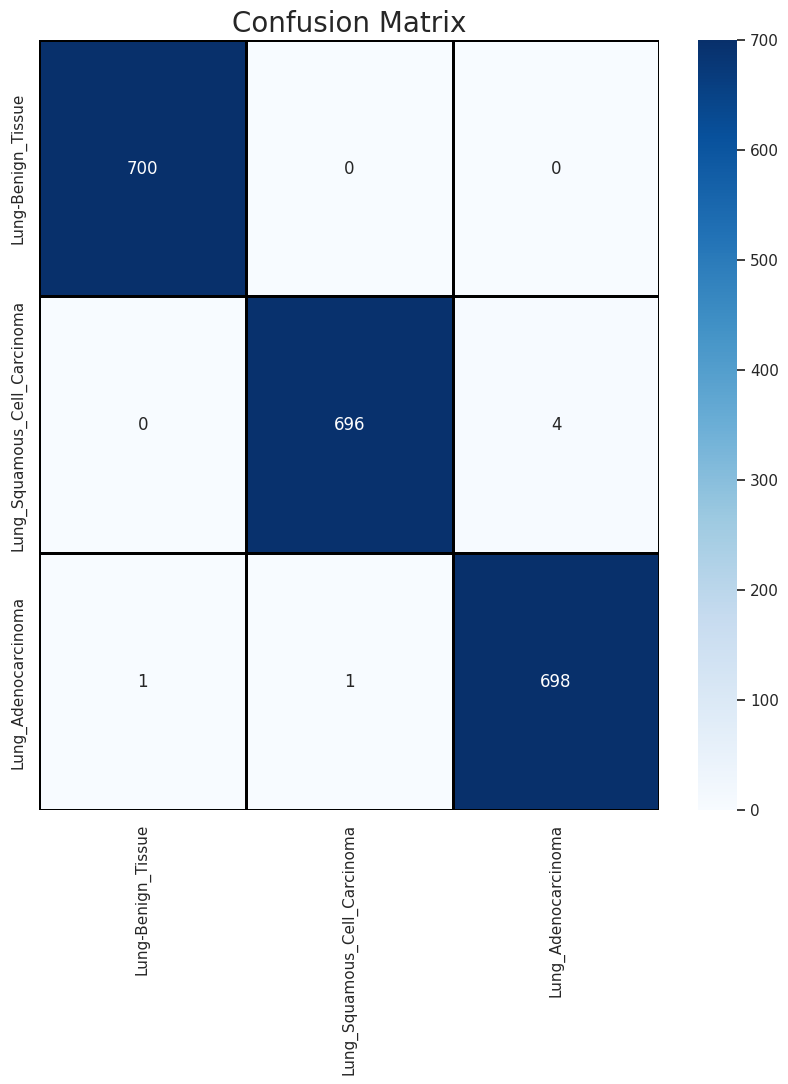

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

66/66 [==============================] - 1s 21ms/step


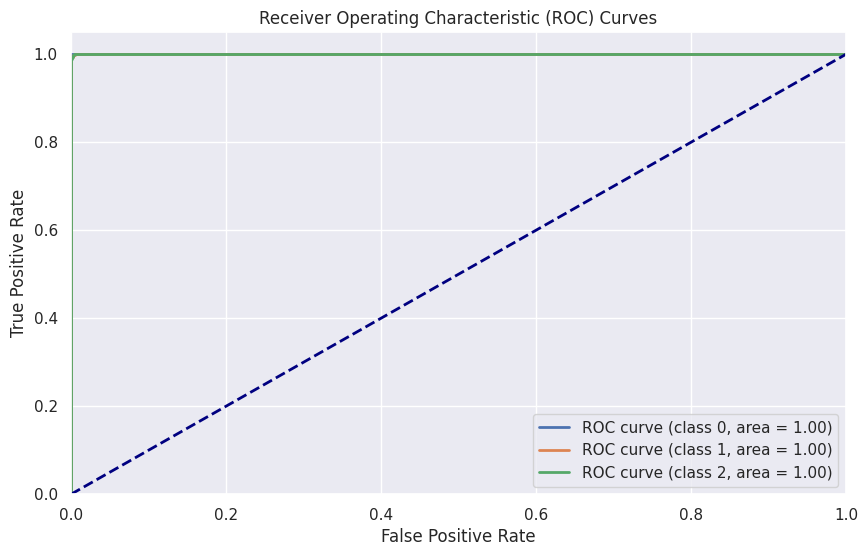

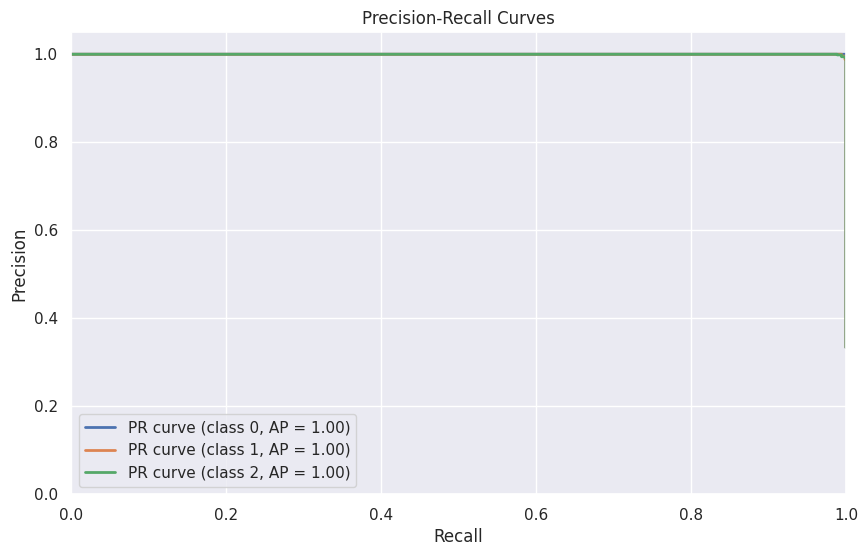

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = e_model_b4.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(e_model_b4.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 1s 21ms/step
                              precision    recall  f1-score   support

          Lung-Benign_Tissue      1.000     1.000     1.000       700
Lung_Squamous_Cell_Carcinoma      0.994     0.997     0.996       700
         Lung_Adenocarcinoma      0.997     0.994     0.996       700

                    accuracy                          0.997      2100
                   macro avg      0.997     0.997     0.997      2100
                weighted avg      0.997     0.997     0.997      2100



<Axes: title={'center': 'Confusion Matrix'}>

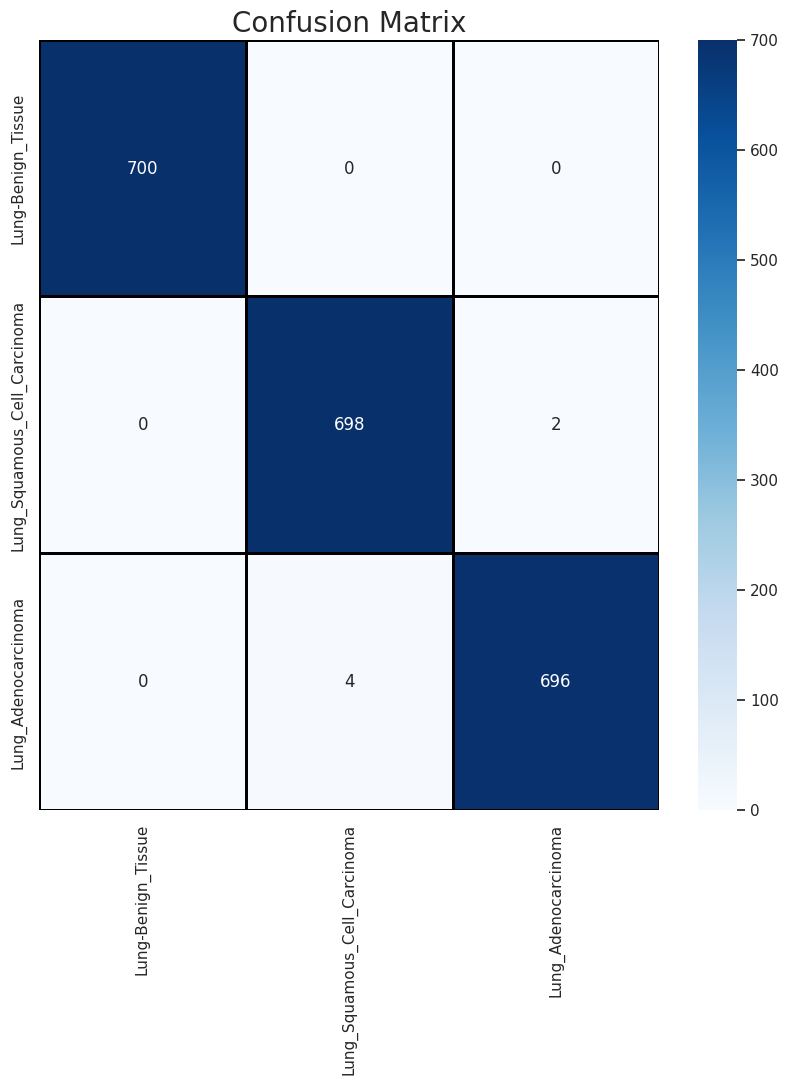

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained weights (include_top=False for feature extraction)
DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of the pre-trained model
for layer in DenseNet121_model.layers:
    layer.trainable = False

# Create a new Sequential model
DenseNet121_custom_model = Sequential()
DenseNet121_custom_model.add(DenseNet121_model)
DenseNet121_custom_model.add(Flatten())
DenseNet121_custom_model.add(Dense(512, activation='relu'))
DenseNet121_custom_model.add(Dense(number_of_classes, activation='softmax'))
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
DenseNet121_custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
DenseNet121_pretrained = DenseNet121_custom_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=96)

Epoch 1/100
263/263 [==============================] - 84s 78ms/step - loss: 0.2281 - accuracy: 0.9188 - val_loss: 2.8345 - val_accuracy: 0.5333
Epoch 2/100
263/263 [==============================] - 17s 66ms/step - loss: 0.0512 - accuracy: 0.9827 - val_loss: 0.0238 - val_accuracy: 0.9910
Epoch 3/100
263/263 [==============================] - 17s 64ms/step - loss: 0.0231 - accuracy: 0.9923 - val_loss: 0.0222 - val_accuracy: 0.9910
Epoch 4/100
263/263 [==============================] - 18s 67ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0298 - val_accuracy: 0.9886
Epoch 5/100
263/263 [==============================] - 18s 67ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0308 - val_accuracy: 0.9900
Epoch 6/100
263/263 [==============================] - 17s 65ms/step - loss: 0.0145 - accuracy: 0.9946 - val_loss: 0.0246 - val_accuracy: 0.9924
Epoch 7/100
263/263 [==============================] - 17s 66ms/step - loss: 0.0137 - accuracy: 0.9951 - val_loss: 0.0543 - val_ac

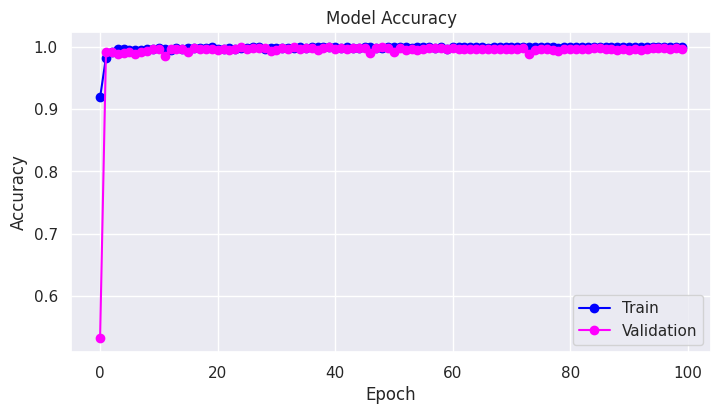

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(DenseNet121_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

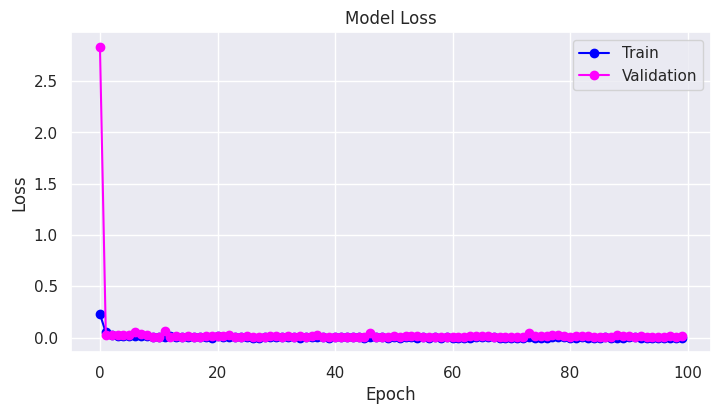

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['loss'],'o-', color="blue")
plt.plot(DenseNet121_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = DenseNet121_custom_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=DenseNet121_custom_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

525/525 [==============================] - 7s 13ms/step - loss: 1.5275e-04 - accuracy: 0.9999

Validation Accuracy: 0.996666669845581

Validation Loss: 0.016497433185577393

Train Accuracy: 0.9999404549598694

Train Loss: 0.0001527494314359501


In [ ]:
score = DenseNet121_custom_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.667 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(DenseNet121_custom_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 2s 11ms/step
                              precision    recall  f1-score   support

          Lung-Benign_Tissue      1.000     1.000     1.000       700
Lung_Squamous_Cell_Carcinoma      0.991     0.999     0.995       700
         Lung_Adenocarcinoma      0.999     0.991     0.995       700

                    accuracy                          0.997      2100
                   macro avg      0.997     0.997     0.997      2100
                weighted avg      0.997     0.997     0.997      2100



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

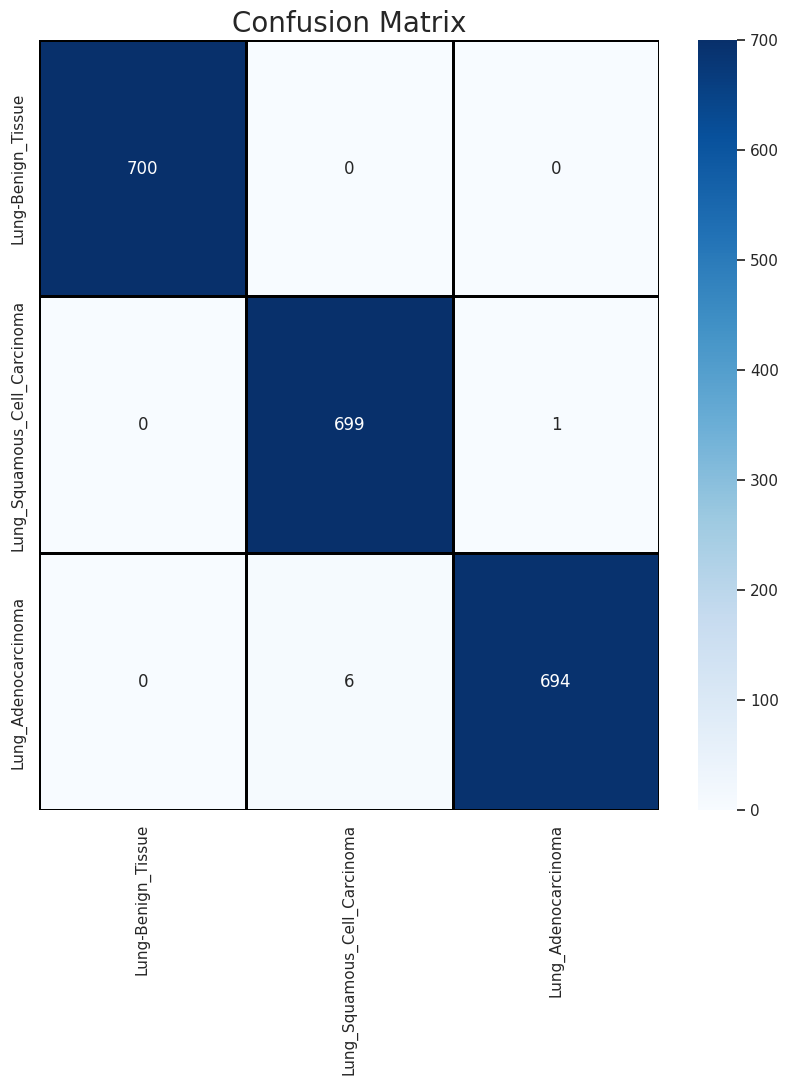

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

66/66 [==============================] - 1s 12ms/step


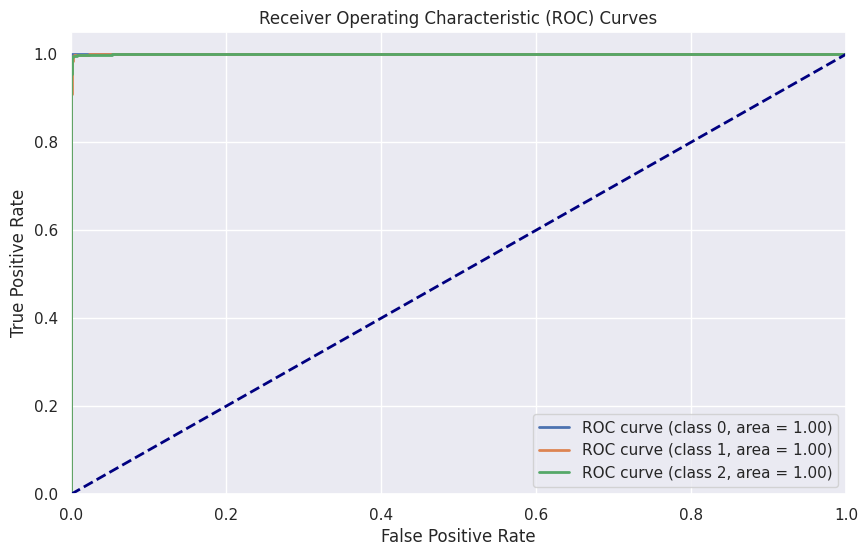

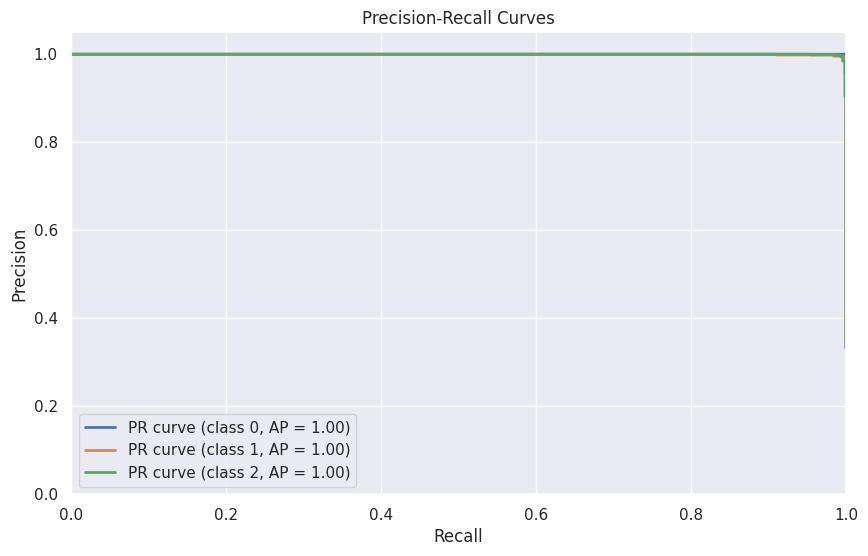

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = DenseNet121_custom_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(DenseNet121_custom_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 1s 11ms/step
                              precision    recall  f1-score   support

          Lung-Benign_Tissue      1.000     1.000     1.000       700
Lung_Squamous_Cell_Carcinoma      0.990     0.997     0.994       700
         Lung_Adenocarcinoma      0.997     0.990     0.994       700

                    accuracy                          0.996      2100
                   macro avg      0.996     0.996     0.996      2100
                weighted avg      0.996     0.996     0.996      2100



<Axes: title={'center': 'Confusion Matrix'}>

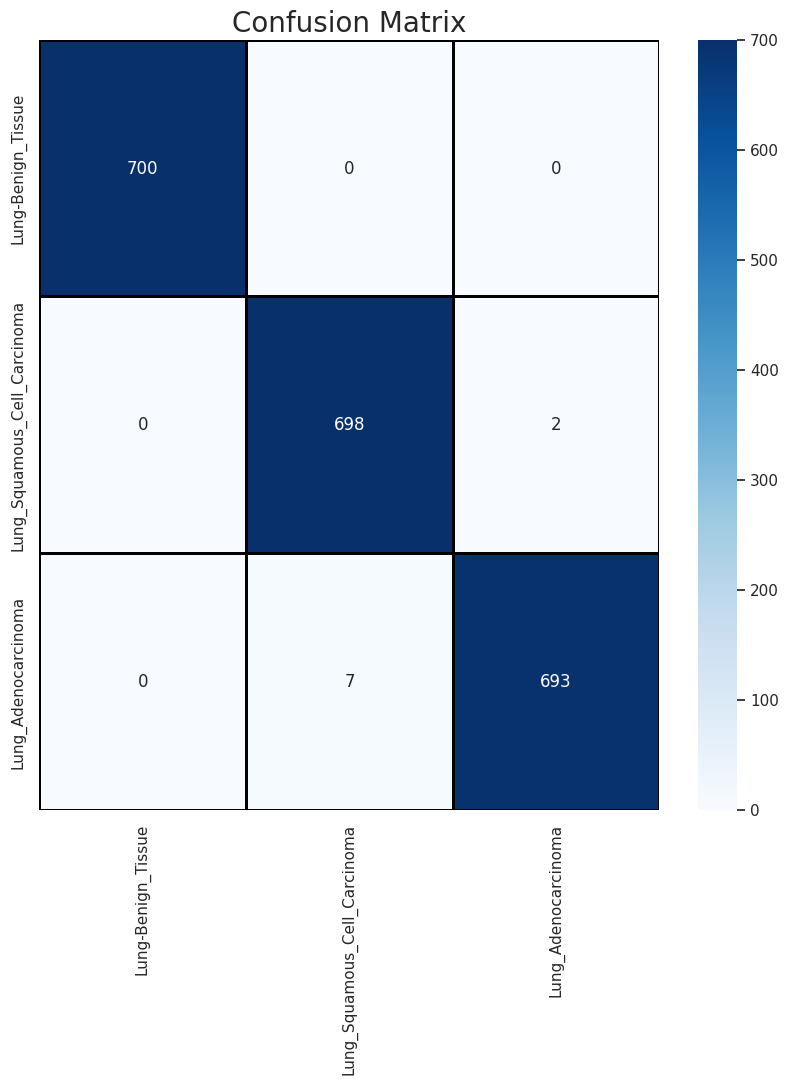

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### AlexNet

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
alexnet_model = keras.Sequential([
    ## input layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='valid'),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=128),
    layers.Activation('relu'),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=10),
    layers.Activation('relu'),

    layers.Dense(number_of_classes),
    layers.Activation('softmax')
])

In [ ]:
alexnet_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet = alexnet_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
263/263 [==============================] - 108s 112ms/step - loss: 0.2507 - accuracy: 0.9115 - val_loss: 2.4598 - val_accuracy: 0.5033
Epoch 2/100
263/263 [==============================] - 23s 89ms/step - loss: 0.0504 - accuracy: 0.9816 - val_loss: 0.0605 - val_accuracy: 0.9767
Epoch 3/100
263/263 [==============================] - 23s 88ms/step - loss: 0.0278 - accuracy: 0.9899 - val_loss: 0.0177 - val_accuracy: 0.9957
Epoch 4/100
263/263 [==============================] - 24s 91ms/step - loss: 0.0183 - accuracy: 0.9943 - val_loss: 0.0117 - val_accuracy: 0.9962
Epoch 5/100
263/263 [==============================] - 24s 90ms/step - loss: 0.0161 - accuracy: 0.9942 - val_loss: 0.0070 - val_accuracy: 0.9981
Epoch 6/100
263/263 [==============================] - 23s 87ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0121 - val_accuracy: 0.9952
Epoch 7/100
263/263 [==============================] - 24s 90ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0058 - val_

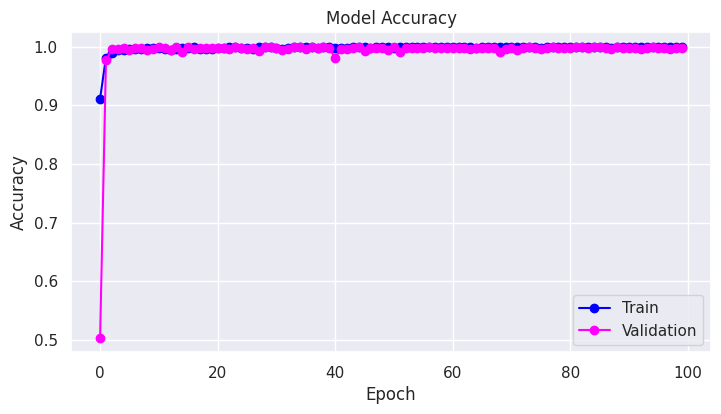

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['accuracy'], 'o-',color="blue")
plt.plot(alexnet.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

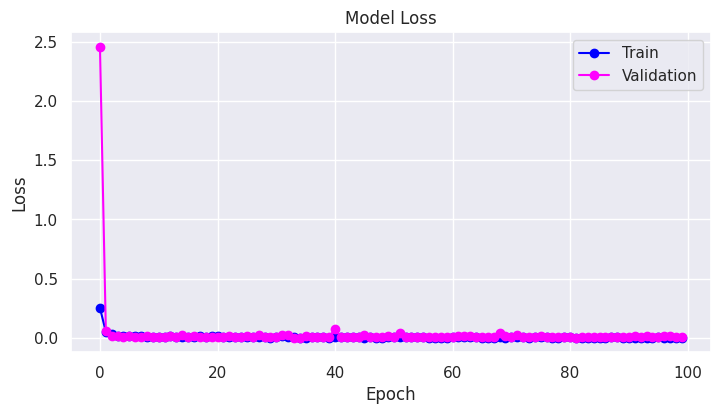

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['loss'],'o-', color="blue")
plt.plot(alexnet.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = alexnet_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=alexnet_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

525/525 [==============================] - 8s 16ms/step - loss: 1.1245e-04 - accuracy: 1.0000

Validation Accuracy: 0.9976190328598022

Validation Loss: 0.007299602963030338

Train Accuracy: 1.0

Train Loss: 0.00011245260975556448


In [ ]:
score = alexnet_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.762 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(bcnn_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 4s 16ms/step
                              precision    recall  f1-score   support

Lung_Squamous_Cell_Carcinoma      0.994     0.999     0.996       700
          Lung-Benign_Tissue      1.000     1.000     1.000       700
         Lung_Adenocarcinoma      0.999     0.994     0.996       700

                    accuracy                          0.998      2100
                   macro avg      0.998     0.998     0.998      2100
                weighted avg      0.998     0.998     0.998      2100



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

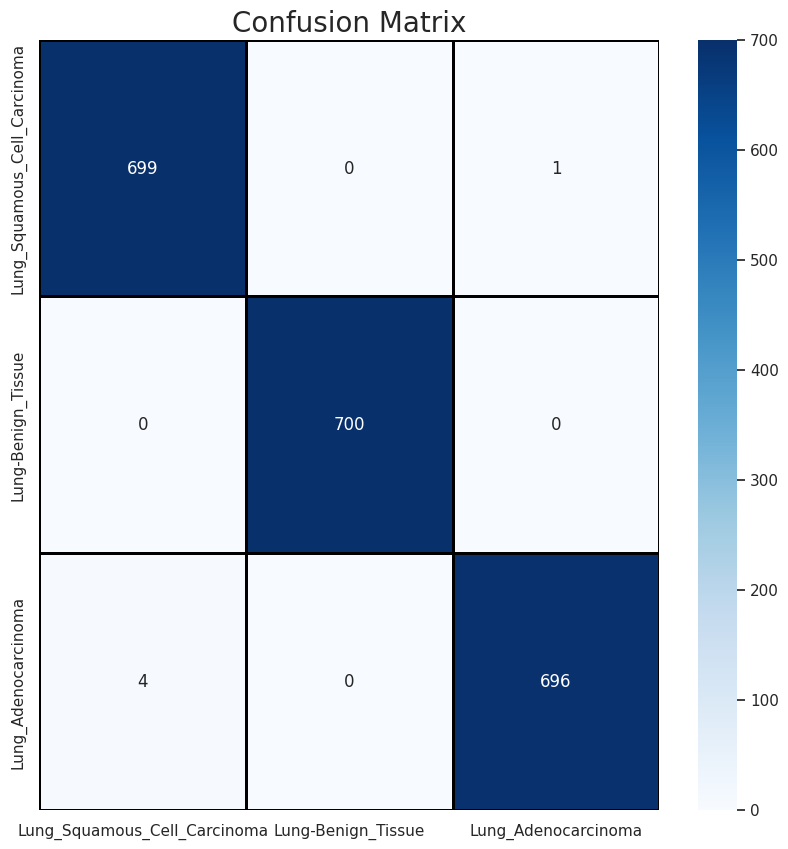

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

66/66 [==============================] - 1s 13ms/step


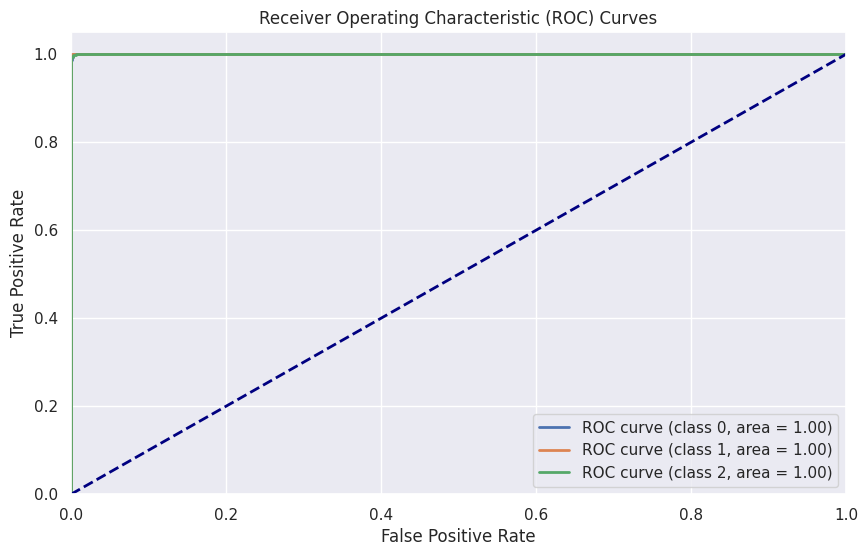

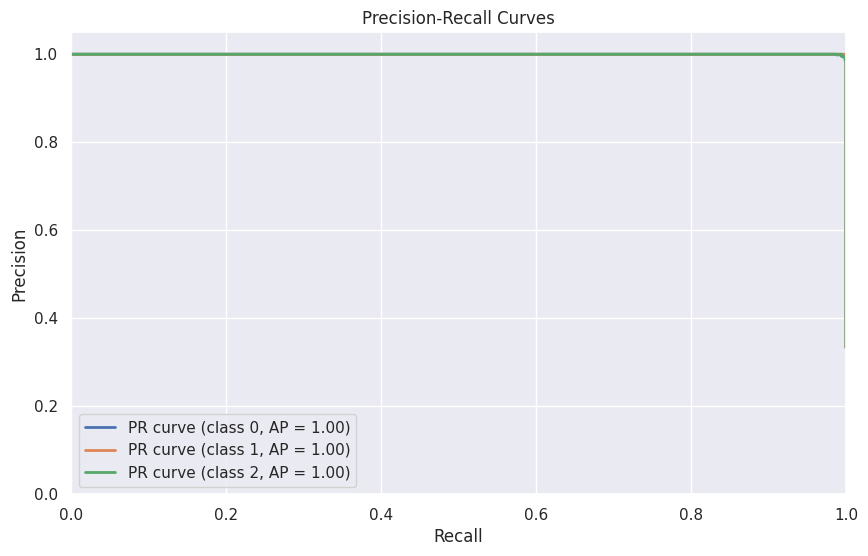

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = alexnet_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(alexnet_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

66/66 [==============================] - 1s 13ms/step
                              precision    recall  f1-score   support

Lung_Squamous_Cell_Carcinoma      0.993     1.000     0.996       700
          Lung-Benign_Tissue      1.000     1.000     1.000       700
         Lung_Adenocarcinoma      1.000     0.993     0.996       700

                    accuracy                          0.998      2100
                   macro avg      0.998     0.998     0.998      2100
                weighted avg      0.998     0.998     0.998      2100



<Axes: title={'center': 'Confusion Matrix'}>

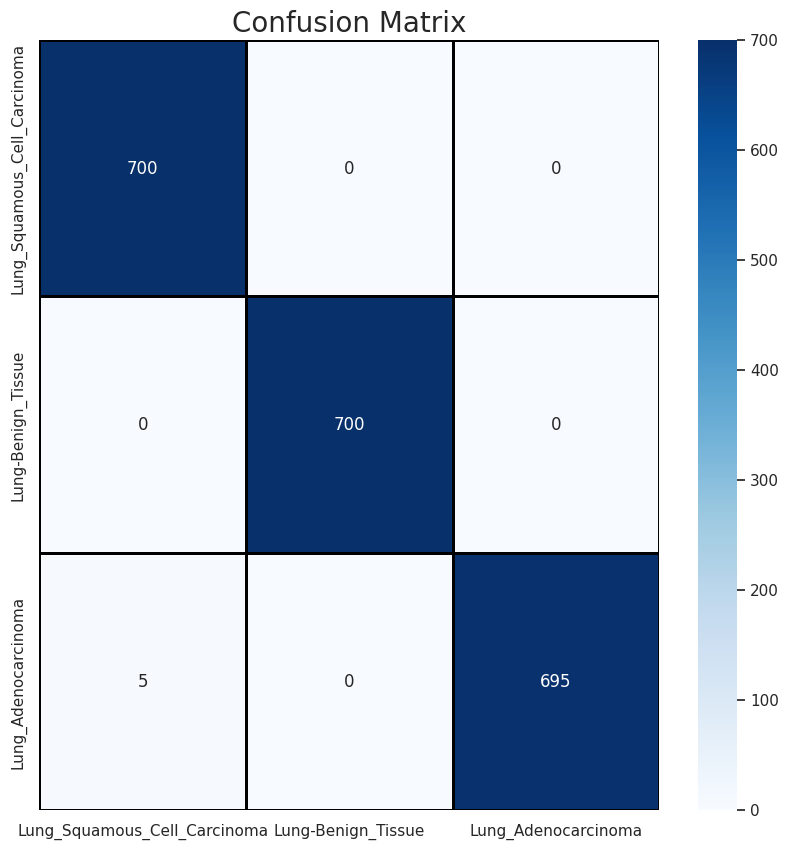

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)